# Functional Programming: Key Principles and Examples


### 1. **Pure Functions**
- **Definition:** A function is pure if its output depends only on its input and has no side effects (like modifying global state, performing I/O operations, or mutating inputs).
- **Why it matters:** JAX transformations like `grad` and `jit` assume that functions are pure. Pure functions ensure predictable behavior when these transformations are applied.
        

In [ ]:
global_state = 0

def impure_function(x):
    global global_state
    global_state += 1  # Modifies global state (side effect)
    return x * global_state  # Output depends on external state

impure_function(3)  # Output depends on global_state
        


**Why this is bad:** The output of the function depends on the external variable `global_state`, which is modified each time the function is called. This makes the function unpredictable, and JAX's transformations (like `grad` or `jit`) will not work reliably on it.
        


### 2. **Immutability**
- **Definition:** In functional programming, data structures are immutable. Once created, they cannot be modified. Any operation that appears to "change" data actually returns a new version of it.
- **Why it matters:** JAX arrays (via `jax.numpy`) are immutable. This is crucial for safe parallel execution and reproducible results, especially when optimizing code for hardware accelerators (like GPUs or TPUs).
        

In [60]:

# Example of mutable operation (Not Allowed)
def mutable_function(arr):
    arr[0] = 100  # Modifies the input array directly
    return arr

x = [1, 2, 3]
mutable_function(x)  # Mutates the original array
print(x)  # x is now [100, 2, 3]
        

[100, 2, 3]



**Why this is bad:** The function mutates the input array `arr`, which violates the immutability principle. In JAX, you should return new arrays rather than modifying existing ones.


### 3. **First-Class Functions**
- **Definition:** Functions are treated as first-class citizens, meaning they can be passed as arguments to other functions, returned as values, or assigned to variables.
- **Why it matters:** Many of JAX's key features (like `vmap`, `grad`, `jit`) are higher-order functions—they take functions as inputs and return new, transformed functions. Understanding how to pass and compose functions is essential.


### 4. **Function Composition**
- **Definition:** Combining multiple simple functions into a more complex function. This is a core idea in functional programming.
- **Why it matters:** In JAX, transformations (like `grad` or `jit`) are applied to entire functions, and you can easily compose these transformations together. For example, you can `jit` a function that returns a gradient (`jit(grad(f))`), or `vmap` a `jit`-compiled function (`vmap(jit(f))`), all while maintaining clean, composable code.
        

In [ ]:

# Example of not composing functions (Not Allowed)
def f1(x):
    return x + 2

def f2(x):
    return x * 3

# Not composing functions (executing them separately)
y = f1(5)
z = f2(y)
        


**Why this is suboptimal:** Here, `f1` and `f2` are called sequentially, rather than being composed into a single function. In JAX, it’s better to compose functions to take advantage of transformations like `jit` and `grad`:
        

In [ ]:

# Better: Composing functions
def composed(x):
    return f2(f1(x))

z = composed(5)
        

In [ ]:

# In JAX, you can also compose transformations like this:
from jax import grad, jit

def func(x):
    return x ** 2 + 3 * x

# Compose grad and jit
grad_jit_func = jit(grad(func))
        


### 5. **No Side Effects**
- **Definition:** A side effect occurs when a function alters something outside its scope, such as modifying global variables, printing output, or changing input data.
- **Why it matters:** JAX transformations assume functions are side-effect-free. Side effects can lead to unpredictable behavior, especially when running code on multiple devices or differentiating through functions.
        

In [6]:

# Example of side effects (Not Allowed)
def function_with_side_effects(x):
    x[0] = 0
    return x * 2

x = [1, 1, 1]
x_m = function_with_side_effects(x)
x, x_m
        

([0, 1, 1], [0, 1, 1, 0, 1, 1])

**Why this is bad:** The function mutates. JAX transformations like `jit` and `grad` work best when functions have no side effects.

# JAX: Key Principles and Examples

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit
from jax import vmap
import matplotlib.pyplot as plt

### 1. **NumPy Compatibility**
JAX provides a NumPy-inspired interface for convenience. Through duck-typing, JAX arrays can often be used as drop-in replacements for NumPy arrays.

2024-09-18 11:23:28.087889: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


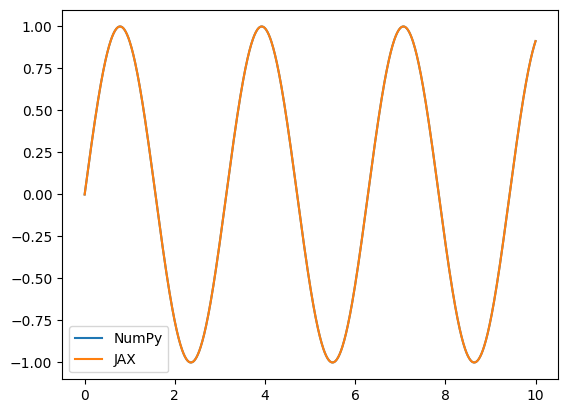

In [2]:
# NumPy
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)

# JAX (JAX arrays can replace NumPy arrays)
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)

# Both will work for plotting
plt.plot(x_np, y_np, label="NumPy")
plt.plot(x_jnp, y_jnp, label="JAX")
plt.legend()
plt.show()

### 2. **Immutability**
Unlike NumPy arrays, JAX arrays are immutable. Once created, they cannot be modified. If you try to mutate JAX arrays, an error will occur.

In [3]:
# NumPy: Mutable arrays
x = np.arange(10)
x[0] = 10  # Works fine in NumPy
print("NumPy Array:", x)

# JAX: Immutable arrays
x_jax = jnp.arange(10)
try:
    x_jax[0] = 10  # This will raise an error in JAX
except TypeError as e:
    print(f"Error: {e}")

# Instead, use indexed update
y_jax = x_jax.at[0].set(10)
print("Original JAX Array:", x_jax)
print("Updated JAX Array:", y_jax)

NumPy Array: [10  1  2  3  4  5  6  7  8  9]
Error: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html
Original JAX Array: [0 1 2 3 4 5 6 7 8 9]
Updated JAX Array: [10  1  2  3  4  5  6  7  8  9]


### 3. **vmap for Automatic Vectorization**
vmap is used to automatically vectorize functions, enabling you to apply the function over batches of data without manually writing loops.

In [4]:
# Function that operates on single data point
def square(x):
    return x ** 2

# Use vmap to apply the function across a batch
batched_square = vmap(square, in_axes=(0))

# Apply over a batch of data
x = jnp.array([1, 2, 3, 4])
print("Batched Results:", batched_square(x))  # [1, 4, 9, 16]


Batched Results: [ 1  4  9 16]


### 4. **jit for Just-In-Time Compilation**
jit is used to compile functions to execute efficiently using XLA, enabling significant speedups.

In [5]:
from jax import jit 
# Function to normalize rows of a matrix
def normalize_rows(X):
    X = X - X.mean(0)
    return X / X.std(0)

# JIT-compiled version of the function
normalize_jit = jit(normalize_rows)

# Input data
X = jnp.array(np.random.rand(1000, 10))

# Timing without jit
%timeit normalize_rows(X).block_until_ready()

# Timing with jit
%timeit normalize_jit(X).block_until_ready()

282 µs ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
62.8 µs ± 6.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 5. **`grad`: Automatic Differentiation in JAX**
JAX provides a `grad` function to compute the gradient (derivative) of another function with respect to its inputs. This is a core feature for tasks like optimization and machine learning.

#### Example Function
Let's define a simple function \( f(x) = x^2 + 3x \). The derivative of this function is easy to compute by hand: \( f'(x) = 2x + 3 \).


In [6]:
import jax.numpy as jnp
from jax import grad

# Define the simple function
def f(x):
    return x**2 + 3*x

x = f(x)

# Compute the gradient using JAX
grad_f = grad(f)

# Test it with an example value
x = 2.0
print("f'(2.0) =", grad_f(x))  # Should return 2 * 2 + 3 = 7

f'(2.0) = 7.0


### 6. **Combining jit and vmap for Speed-up**

In [7]:
# JIT-compiled, vectorized gradient function
# Vectorized version of the gradient function
vmap_grad_f = vmap(grad_f)

# Test on a batch of values
x_batch = jnp.array([1.0, 2.0, 3.0])

jit_vmap_grad_f = jit(vmap(grad_f))

# Timing the vectorized and JIT-compiled version
%timeit vmap_grad_f(x_batch).block_until_ready()  # Without JIT
%timeit jit_vmap_grad_f(x_batch).block_until_ready()  # With JIT


5.23 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.6 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### 7. **State management in JAX**

In [8]:
import jax
import jax.numpy as jnp
from jax import jit

# Define a simple Counter class
class Counter:
    """A simple counter that maintains internal state."""
    
    def __init__(self):
        self.n = 0  # Internal state

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1  # This modifies the internal state
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0

# Create an instance of the Counter
counter = Counter()

# Test the counter
for _ in range(3):
    print(counter.count())  # Expected output: 1, 2, 3


1
2
3


Lets jit it to get some speed up

In [9]:
counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    print(fast_count())  # Output will be incorrect: 1, 1, 1


1
1
1


**Fix: Using Explicit State Management**
To handle state properly in JAX, we pass the state explicitly as a function argument and return the updated state as part of the output.

In [10]:
# Define a new Counter class with explicit state
class CounterV2:
    
    def count(self, n: int) -> tuple[int, int]:
        """Increments the counter and returns the new value and updated state."""
        return n + 1, n + 1  # Return updated value and state

    def reset(self) -> int:
        """Resets the counter state."""
        return 0

# Create an instance of the new Counter
counter_v2 = CounterV2()
state = counter_v2.reset()

# Test with manual state management
for _ in range(3):
    value, state = counter_v2.count(state)
    print(value)  # Expected output: 1, 2, 3


1
2
3


We can now jit the process

In [11]:
# JIT-compile the count method
fast_count_v2 = jit(counter_v2.count)

# Reset state and test with JIT
state = counter_v2.reset()
for _ in range(3):
    value, state = fast_count_v2(state)
    print(value)  # Expected output: 1, 2, 3


1
2
3


# MJX: Key Principles and Examples

### 1. **`Creating a model and data**
Mujoco API model works with two structures: model and data. All functions perform their computation using these two structures, which should be passed in as arguments. MJX is the JAX version of MUJOCO and XLA is the compiler that handles JIT VMAP and GRAD in JAX and JAX is a DL/LA library

In [17]:
import mujoco
from mujoco import mjx

# all on CPU side
model = mujoco.MjModel.from_xml_path("./xmls/cartpole.xml")
data = mujoco.MjData(model)

# send to GPU side
mx = mjx.put_model(model)
dx = mjx.make_data(mx)

### 2. **Stepping the model given initial conditions**
Mujoco API model works with two structures: model and data. All functions perform their computation using these two structures, which should be passed in as arguments.

In [18]:
init_key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(init_key)
batch = 100    
x_init = jnp.concatenate([
            jax.random.uniform(key, (batch, 1), minval=-0.1, maxval=0.1),
            jax.random.uniform(key, (batch, 1), minval=-0.1, maxval=0.1),
            jax.random.uniform(key, (batch, 1), minval=-0.1, maxval=0.1),
            jax.random.uniform(key, (batch, 1), minval=-0.1, maxval=0.1)
        ], axis=1).squeeze()

We now need to pass this batch of initial condition to function that can set our states (pos and vel). Hint: vmap

In [19]:
def set_init(x):
    dx = mjx.make_data(mx)
    qpos = dx.qpos.at[:].set(x[:mx.nq])
    qvel = dx.qvel.at[:].set(x[mx.nq:])
    dx = dx.replace(qpos=qpos, qvel=qvel)
    return dx

# get the new dx with a batch of states
dx = jax.vmap(set_init, in_axes=(0))(x_init)

In [20]:
dx.qvel.shape

(100, 2)

### 3. How do we step over multiple times?
Sequential operations in Jax are done via scan. 
'''
    def scan(f, init, xs, length=None):
      if xs is None:
        xs = [None] * length
      carry = init
      ys = []
      for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
      return carry, np.stack(ys)
'''      

In [21]:
def simulate(x_init, mx):

    def set_init(x):
        dx = mjx.make_data(mx)
        qpos = dx.qpos.at[:].set(x[:mx.nq])
        qvel = dx.qvel.at[:].set(x[mx.nq:])
        dx = dx.replace(qpos=qpos, qvel=qvel)
        return dx

    def mjx_step(dx, _):
        dx = mjx.step(mx, dx)
        # dx = set_ctrl(dx)
        return dx, jnp.concatenate([dx.qpos, dx.qvel, dx.ctrl], axis=0) # CARRY, YS

    dx = set_init(x_init)
    _, batched_traj = jax.lax.scan(mjx_step, dx, None, length=100)
    x, u = batched_traj[..., :-mx.nu], batched_traj[..., -mx.nu:]
    return x, u

now lets vmap and simulate

In [22]:
simulate_vmapped = jax.vmap(simulate, in_axes=(0, None))
x, u = simulate_vmapped(x_init, mx)

In [23]:
x.shape, u.shape

((100, 100, 4), (100, 100, 1))

will jitting make a difference?

In [24]:
# Jitted version of vmap
import timeit
simulate_jit_vmapped = jit(simulate_vmapped)

print("Timing non-JIT version:")
%timeit simulate_vmapped(x_init, mx)  # Non-JIT version

print("Timing JIT version:")
%timeit simulate_jit_vmapped(x_init, mx)  # JIT version

# Check results are the same
x_non_jit = simulate_vmapped(x_init, mx)
x_jit = simulate_jit_vmapped(x_init, mx)

Timing non-JIT version:
12.3 s ± 97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Timing JIT version:
38.6 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
